In [14]:
import pandas as pd
import numpy as np
from math import sqrt

from clearml import Task
import argparse

import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score

In [8]:
task = Task.init(project_name="Dataset_g5", task_name="Catboost_train")

ClearML Task: created new task id=4591cc2341c74217a5ccf2943ee18794
2023-12-29 18:49:33,840 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/1db2548eb69c4c26883ef321cdc663bf/experiments/4591cc2341c74217a5ccf2943ee18794/output/log


ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


In [18]:
parser = argparse.ArgumentParser()
parser.add_argument("-iterations", default=30, help="iterations boosting")
parser.add_argument("-depth", default=3, help="depth tree")
parser.add_argument("-loss_function", default="MAE", help="loss function")

args = parser.parse_known_args()

In [9]:
def prepare_obj_data(df, obj_cols):
    """
    Prepare data with type object

    Args:
        df: pd.DataFrame
        obj_cols: list of str
    Returns:
        pd.DataFrame
    """

    cheat_count_is_cheater = df["is_cheater"].value_counts().index[0]
    cheat_count_has_email = df["has_email"].value_counts().index[0]

    df["is_cheater"] = df["is_cheater"].fillna(cheat_count_is_cheater)
    df["has_email"] = df["has_email"].fillna(cheat_count_has_email)

    df["country"] = df["country"].fillna("other")
    df["network_name"] = df["network_name"].fillna("other")

    encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")
    for column in obj_cols:
        encoded_data = encoder.fit_transform(df[[column]])
        encoded_df = pd.DataFrame(
            encoded_data, columns=encoder.get_feature_names_out([column])
        )
        df = pd.concat([df, encoded_df], axis=1)

    df.drop(obj_cols, axis=1, inplace=True)

    return df

In [10]:
def plot_importance(model, X):
    """
    Function for plot regression coef
    """
    try:
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = X.columns
        fold_importance_df["importance"] = model.feature_importances_
        td = fold_importance_df.sort_values("importance", ascending=False)
        sns.barplot(x="importance", y="feature", data=td.head(10), palette="Blues_d")
        plt.show()
    except:
        return []


def SMAPE(y_true, y_pred):
    """
    SMAPE score
    """
    denominator = np.abs(y_true) + np.abs(y_pred)
    diff = np.where(denominator == 0, 0, 2 * np.abs(y_true - y_pred) / denominator)
    return np.mean(diff)


def custom_smape_score(estimator, X, y):
    """
    SMAP for cross-validation
    """
    y_pred = estimator.predict(X)
    smape = SMAPE(y, y_pred)
    return -smape


def train_model(model_obj, X_train, y_train, num_folds, scoring, cross_val=False):
    """
    Train model
    """
    model = model_obj
    print(model.fit(X_train, y_train, verbose=50, plot=True))

    if cross_val:
        cv_scores = cross_val_score(
            model, X_train, y_train, cv=num_folds, scoring=scoring
        )
        print("Cross_validation:", cv_scores)

    td = plot_importance(model, X_train)

    return model, td

In [11]:
df = pd.read_csv("dataset.csv", index_col=0)

df.drop(
    ["date_install", "first_command_time", "birthday", "sex", "time_confirm_email"],
    axis=1,
    inplace=True,
)
int_cols = df.select_dtypes(include=["int", "float"]).columns
int_cols = int_cols.drop("target_game_currency")
obj_cols = ["country", "network_name"]


In [12]:
df = prepare_obj_data(df, obj_cols)
X = df.drop("target_game_currency", axis=1)
y = df["target_game_currency"]

y_stratified = (y > 0).astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, stratify=y_stratified, random_state=42
)

/Users/kurmangazykarabekov/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/Users/kurmangazykarabekov/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [19]:
params = {
    "iterations": 230,
    "depth": 3,
    "loss_function": "MAE",
    "random_state": 42,
    "l2_leaf_reg": 20,
    "verbose": 50,
    "early_stopping_rounds": 20,
    "thread_count": -1,
}

In [20]:
task.connect(params)

{'iterations': 230,
 'depth': 3,
 'loss_function': 'MAE',
 'random_state': 42,
 'l2_leaf_reg': 20,
 'verbose': 50,
 'early_stopping_rounds': 20,
 'thread_count': -1}

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 484.1682889	total: 129ms	remaining: 29.5s
50:	learn: 433.8854273	total: 2.35s	remaining: 8.25s
100:	learn: 428.9690557	total: 4.45s	remaining: 5.69s
150:	learn: 428.4892535	total: 6.67s	remaining: 3.49s
200:	learn: 427.9060742	total: 8.79s	remaining: 1.27s
229:	learn: 427.5022304	total: 10.1s	remaining: 0us
0:	learn: 488.9098849	total: 65ms	remaining: 14.9s
50:	learn: 437.3353180	total: 2.22s	remaining: 7.79s
100:	learn: 431.6915648	total: 3.89s	remaining: 4.97s
150:	learn: 430.5938317	total: 6.27s	remaining: 3.28s
200:	learn: 430.1702938	total: 8.27s	remaining: 1.19s
229:	learn: 430.0639143	total: 9.24s	remaining: 0us
0:	learn: 486.9009092	total: 92.3ms	remaining: 21.1s
50:	learn: 436.7346234	total: 1.95s	remaining: 6.85s
100:	learn: 432.6951143	total: 3.65s	remaining: 4.66s
150:	learn: 431.1393834	total: 5.3s	remaining: 2.77s
200:	learn: 430.7188505	total: 7.01s	remaining: 1.01s
229:	learn: 430.7100463	total: 8.07s	remaining: 0us
0:	learn: 482.8489335	total: 43.5ms	remainin

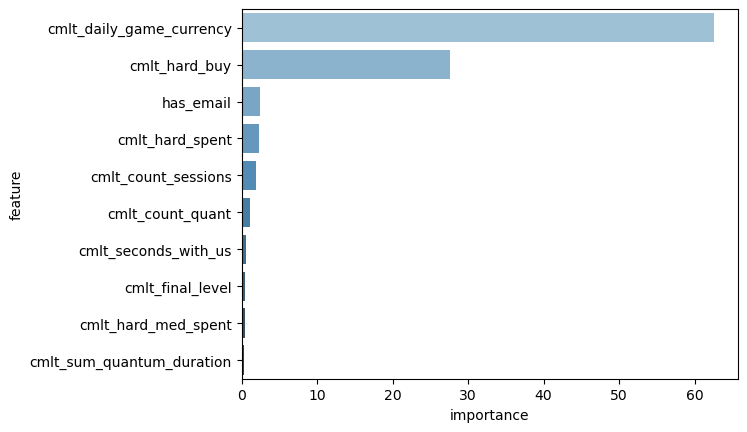

In [22]:


model, features = train_model(
    CatBoostRegressor(**params),
    X_train,
    y_train,
    5,
    scoring="neg_mean_absolute_error",
    cross_val=True,
)